In [1]:
import pandas as pd
from sodapy import Socrata
import pyspark
import json
import matplotlib.pyplot as plt
import numpy as np

conf = pyspark.SparkConf()
conf.set('spark.driver.memory', '16g')

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)

import dask.dataframe as dd
from dask_glm.datasets import make_regression
from dask_ml.linear_model import LinearRegression

from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/08 20:16:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/08 20:16:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/08 20:16:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
from pyspark.sql.functions import desc


In [3]:
test_data_path = '/Users/maludee/repos/Big-Data-Project/data/Parking_Violations_Issued_-_Fiscal_Year_2023.csv'
open_data_path = '/Users/maludee/repos/Big-Data-Project/data/Open_Parking_and_Camera_Violations.csv'
precinct_data_path = "/Users/maludee/repos/Big-Data-Project/data/nypp.csv"

# Precinct Map for Tableau

In [4]:
# YEARLY PARKING DATA - FOR TABLEAU
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(test_data_path)

df.repartition(1).write.mode('overwrite').parquet('tmp/parking_2023')

df = spark.read.parquet('/Users/maludee/repos/Big-Data-Project/notebooks/tmp/parking_2023/*.parquet')

23/05/08 19:32:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
df.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Time First Observed: string (nullable = true)
 |-- Violation Coun

In [6]:
precinct_keys = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(precinct_data_path)
precinct_keys.show(5)

+--------------------+--------+-------------+---------------+
|            the_geom|Precinct|   Shape_Leng|     Shape_Area|
+--------------------+--------+-------------+---------------+
|MULTIPOLYGON (((-...|       1|80283.5387782|4.72864229826E7|
|MULTIPOLYGON (((-...|       5|18807.1249114|1.80945274385E7|
|MULTIPOLYGON (((-...|       6|24875.9642171|2.20179465474E7|
|MULTIPOLYGON (((-...|       7|17287.5444926| 1.8366669928E7|
|MULTIPOLYGON (((-...|       9|19772.5107407|2.13953862669E7|
+--------------------+--------+-------------+---------------+
only showing top 5 rows



In [7]:
# use sql syntax to parse the nested json
df.createOrReplaceTempView("2023_violations")
query = """
select 
    `Violation Precinct` as violation_precinct,
    count(*) as count_violations
from 
    2023_violations
group by 1
order by 2 desc

"""
precincts = spark.sql(query)
precincts.toPandas().to_csv('violations_by_precinct.csv')

# I think precinct 0 is in error and should be ignored
precincts.show(6)

+------------------+----------------+
|violation_precinct|count_violations|
+------------------+----------------+
|                 0|         5938384|
|                19|          331642|
|                13|          291119|
|                 6|          259154|
|               114|          254978|
|                14|          220291|
+------------------+----------------+
only showing top 6 rows



# ML Section

In [4]:
# OPEN DATASET - FOR MACHINE LEARNING 
# df = spark.read \
#     .option("header", "true") \
#     .option("inferSchema", "true") \
#     .csv(open_data_path)

# df.repartition(1).write.mode('overwrite').parquet('tmp/open_parking_full')

# read in the open data violations file
df = spark.read.parquet('/Users/maludee/repos/Big-Data-Project/notebooks/tmp/open_parking_full/*.parquet')

In [5]:
df.limit(3).toPandas()

,Plate,State,License Type,Summons Number,Issue Date,Violation Time,Violation,Judgment Entry Date,Fine Amount,Penalty Amount,Interest Amount,Reduction Amount,Payment Amount,Amount Due,Precinct,County,Issuing Agency,Violation Status,Summons Image
0,DEMAR12,NY,COM,8766059240,09/09/2019,10:49A,NO PARKING-DAY/TIME LIMITS,None,65.0,0.0,0.0,40.0,25.0,0.0,10,NY,TRAFFIC,HEARING HELD-GUILTY REDUCTION,View Summons (http://nycserv.nyc.gov/NYCServWe...
1,ZBC17M,NJ,PAS,4690039010,05/12/2020,04:16P,PHTO SCHOOL ZN SPEED VIOLATION,None,50.0,0.0,0.0,0.0,50.0,0.0,0,MN,DEPARTMENT OF TRANSPORTATION,None,View Summons (http://nycserv.nyc.gov/NYCServWe...
2,GKB2709,NY,PAS,4693856617,06/04/2020,02:37P,PHTO SCHOOL ZN SPEED VIOLATION,None,50.0,0.0,0.0,0.0,50.0,0.0,0,BK,DEPARTMENT OF TRANSPORTATION,None,View Summons (http://nycserv.nyc.gov/NYCServWe...


In [6]:
# select a subset of columns for the model (TODO: add more)
df = df.na.drop() \
    .filter((col("Precinct") >= "1") & (col("Precinct") <= "124")) \
    .select([col("State"), col("License Type"), col("Violation"), 
             col("Fine Amount"), col("Violation Time"), 
             col("Issue Date"), col("Precinct")])

In [7]:
df.limit(3).toPandas()

,State,License Type,Violation,Fine Amount,Violation Time,Issue Date,Precinct
0,NY,PAS,FIRE HYDRANT,115.0,07:16A,11/26/2017,75
1,NY,PAS,FRONT OR BACK PLATE MISSING,65.0,08:21A,07/10/2022,121
2,NY,PAS,NO PARKING-STREET CLEANING,65.0,10:22A,08/01/2022,83


In [9]:
# make into a temp sql view for convenience 
df.createOrReplaceTempView("open_violations")

query = """

    select 
        case when lower(`State`) = 'ny' then 1 else 0 end as in_state,
        case when lower(`License Type`) = 'pas' then 1 else 0 end as passenger_car,
        -- `Violation Time`,
        -- CASE WHEN SUBSTRING(`Violation Time`, -1) = 'A' 
        --    THEN SUBSTRING(`Violation Time`, 1, 2)
        --    ELSE CAST(CAST(SUBSTRING(`Violation Time`, 1, 2) AS INT) + 12 AS STRING)
        --    END AS violation_hour,
        case when (CASE WHEN SUBSTRING(`Violation Time`, -1) = 'A' 
            THEN SUBSTRING(`Violation Time`, 1, 2)
            ELSE CAST(CAST(SUBSTRING(`Violation Time`, 1, 2) AS INT) + 12 AS STRING)
            END) between 9 and 18 then 1 else 0 end as business_hours,
        --`Issue Date` as issue_date,
        --  dayofweek(to_date(`Issue Date`, 'MM/dd/yyyy')) as day_of_week,
        extract(year from (to_date(`Issue Date`, 'MM/dd/yyyy'))) as year,
        case when dayofweek(to_date(`Issue Date`, 'MM/dd/yyyy')) = 1 then 1 
        when dayofweek(to_date(`Issue Date`, 'MM/dd/yyyy')) = 7 then 1 else 0 end as is_weekend,

        case when Precinct >= 1 AND Precinct <= 40 then 1 else 0 end as Manhattan,
        case when Precinct >= 40 AND Precinct <= 60 then 1 else 0 end as Bronx,
        case when Precinct >= 60 AND Precinct <= 100 then 1 else 0 end as Brooklyn,
        case when Precinct >= 100 AND Precinct <= 120 then 1 else 0 end as Queens,
        case when Precinct >= 120 AND Precinct <= 125 then 1 else 0 end as Staten_Island,

        case when Violation = 'NO PARKING-STREET CLEANING' then 1 else 0 end as NO_PARKING_STREET_CLEANING,
        case when Violation = 'INSP. STICKER-EXPIRED/MISSING' then 1 else 0 end as INSP_STICKER_EXPIRED_MISSING,
        case when Violation = 'FAIL TO DSPLY MUNI METER RECPT' then 1 else 0 end as FAIL_TO_DSPLY_MUNI_METER_RECPT,
        case when Violation = 'NO STANDING-DAY/TIME LIMITS' then 1 else 0 end as NO_STANDING_DAY_TIME_LIMITS,
        case when Violation = 'FIRE HYDRANT' then 1 else 0 end as FIRE_HYDRANT,
        case when Violation = 'REG. STICKER-EXPIRED/MISSING' then 1 else 0 end as REG_STICKER_EXPIRED_MISSING,
        case when Violation = 'NO PARKING-DAY/TIME LIMITS' then 1 else 0 end as NO_PARKING_DAY_TIME_LseIMITS,
        case when Violation = 'DOUBLE PARKING' then 1 else 0 end as DOUBLE_PARKING,
        case when Violation = 'EXPIRED MUNI METER' then 1 else 0 end as EXPIRED_MUNI_METER,
        case when Violation = 'FRONT OR BACK PLATE MISSING' then 1 else 0 end as FRONT_OR_BACK_PLATE_MISSING,
        case when Violation = 'NO STANDING-BUS STOP' then 1 else 0 end as NO_STANDING_BUS_STOP,
        case when Violation = 'NO STANDING-COMM METER ZONE' then 1 else 0 end as NO_STANDING_COMM_METER_ZONE,
        case when Violation = 'FAIL TO DISP. MUNI METER RECPT' then 1 else 0 end as FAIL_TO_DISP_MUNI_METER_RECPT,
        case when Violation = 'NO STANDING-EXC. TRUCK LOADING' then 1 else 0 end as NO_STANDING_EXC_TRUCK_LOADING,
        case when Violation = 'CROSSWALK' then 1 else 0 end as CROSSWALK,
        case when Violation = 'NO STANDING-EXC. AUTH. VEHICLE' then 1 else 0 end as NO_STANDING_EXC_AUTH_VEHICLE,
        case when Violation = 'DOUBLE PARKING-MIDTOWN COMML' then 1 else 0 end as DOUBLE_PARKING_MIDTOWN_COMML,
        case when Violation = 'SIDEWALK' then 1 else 0 end as SIDEWALK,
        case when Violation = 'BIKE LANE' then 1 else 0 end as BIKE_LANE,
        case when Violation = 'NO MATCH-PLATE/STICKER' then 1 else 0 end as NO_MATCH_PLATE_STICKER,
        case when Violation = 'PLTFRM LFTS LWRD POS COMM VEH' then 1 else 0 end as PLTFRM_LFTS_LWRD_POS_COMM_VEH,
        case when Violation = 'SAFETY ZONE' then 1 else 0 end as SAFETY_ZONE,
        case when Violation = 'OBSTRUCTING DRIVEWAY' then 1 else 0 end as OBSTRUCTING_DRIVEWAY,
        case when Violation = 'NO STOPPING-DAY/TIME LIMITS' then 1 else 0 end as NO_STOPPING_DAY_TIME_LIMITS,
        case when Violation = 'COMML PLATES-UNALTERED VEHICLE' then 1 else 0 end as COMML_PLATES_UNALTERED_VEHICLE,
        case when Violation = 'NGHT PKG ON RESID STR-COMM VEH' then 1 else 0 end as NGHT_PKG_ON_RESID_STR_COMM_VEH,
        case when Violation = 'EXPIRED MUNI MTR-COMM MTR ZN' then 1 else 0 end as EXPIRED_MUNI_MTR_COMM_MTR_ZN,
        case when Violation = 'OBSTRUCTING TRAFFIC/INTERSECT' then 1 else 0 end as OBSTRUCTING_TRAFFIC_INTERSECT,
        case when Violation = 'NO STANDING-BUS LANE' then 1 else 0 end as NO_STANDING_BUS_LANE,
        case when Violation = 'INSP STICKER-MUTILATED/CFEIT' then 1 else 0 end as INSP_STICKER_MUTILATED_C_FEIT,
        case when Violation = 'STORAGE-3HR COMMERCIAL' then 1 else 0 end as STORAGE_3HR_COMMERCIAL,
        case when Violation = 'NON-COMPLIANCE W/ POSTED SIGN' then 1 else 0 end as NON_COMPLIANCE_W_POSTED_SIGN,
        case when Violation = 'NO STANDING-TAXI STAND' then 1 else 0 end as NO_STANDING_TAXI_STAND,
        case when Violation = 'NO PARKING-EXC. AUTH. VEHICLE' then 1 else 0 end as NO_PARKING_EXC_AUTH_VEHICLE,
        case when Violation = 'PEDESTRIAN RAMP' then 1 else 0 end as PEDESTRIAN_RAMP,
        case when Violation = 'PARKED BUS-EXC. DESIG. AREA' then 1 else 0 end as PARKED_BUS_EXC_DESIG_AREA,
        case when Violation = 'WRONG WAY' then 1 else 0 end as WRONG_WAY,
        case when Violation = 'SELLING/OFFERING MCHNDSE-METER' then 1 else 0 end as SELLING_OFFERING_MCHNDSE_METER,
        case when Violation = 'EXPIRED METER' then 1 else 0 end as EXPIRED_METER,
        case when Violation = 'NO STANDING-HOTEL LOADING' then 1 else 0 end as NO_STANDING_HOTEL_LOADING,
        case when Violation = 'REG STICKER-MUTILATED/CFEIT' then 1 else 0 end as REG_STICKER_MUTILATED_C_FEIT,
        case when Violation = 'NO STANDING EXCP D/S' then 1 else 0 end as NO_STANDING_EXCP_D_S,
        case when Violation = 'ANGLE PARKING' then 1 else 0 end as ANGLE_PARKING,
        case when Violation = 'IMPROPER REGISTRATION' then 1 else 0 end as IMPROPER_REGISTRATION,
        case when Violation = 'NO PARKING-EXC. HNDICAP PERMIT' then 1 else 0 end as NO_PARKING_EXC_HNDICAP_PERMIT,
        case when Violation = 'TRAFFIC LANE' then 1 else 0 end as TRAFFIC_LANE,
        case when Violation = 'BEYOND MARKED SPACE' then 1 else 0 end as BEYOND_MARKED_SPACE,
        case when Violation = 'NO PARKING-EXC. HOTEL LOADING' then 1 else 0 end as NO_PARKING_EXC_HOTEL_LOADING,
        case when Violation = 'MISSING EQUIPMENT' then 1 else 0 end as MISSING_EQUIPMENT,
        case when Violation = 'FEEDING METER' then 1 else 0 end as FEEDING_METER,
        case when Violation = 'OVERTIME PKG-TIME LIMIT POSTED' then 1 else 0 end as OVERTIME_PKG_TIME_LIMIT_POSTED,
        case when Violation = 'DETACHED TRAILER' then 1 else 0 end as DETACHED_TRAILER,
        case when Violation = 'TUNNEL/ELEVATED/ROADWAY' then 1 else 0 end as TUNNEL_ELEVATED_ROADWAY,
        case when Violation = 'UNAUTHORIZED BUS LAYOVER' then 1 else 0 end as UNAUTHORIZED_BUS_LAYOVER,
        case when Violation = 'NO PARKING-TAXI STAND' then 1 else 0 end as NO_PARKING_TAXI_STAND,
        case when Violation = 'OTHER' then 1 else 0 end as OTHER,
        case when Violation = 'VIN OBSCURED' then 1 else 0 end as VIN_OBSCURED,
        case when Violation = 'IDLING' then 1 else 0 end as IDLING,
        case when Violation = 'NO STD(EXC TRKS/GMTDST NO-TRK)' then 1 else 0 end as NO_STD_EXC_TRKS_GMTDST_NO_TRK,
        case when Violation = 'OVERNIGHT TRACTOR TRAILER PKG' then 1 else 0 end as OVERNIGHT_TRACTOR_TRAILER_PKG,
        case when Violation = 'INTERSECTION' then 1 else 0 end as INTERSECTION,
        case when Violation = 'UNALTERED COMM VEHICLE' then 1 else 0 end as UNALTERED_COMM_VEHICLE,
        case when Violation = 'FAILURE TO DISPLAY BUS PERMIT' then 1 else 0 end as FAILURE_TO_DISPLAY_BUS_PERMIT,
        case when Violation = 'NO STANDING-FOR HIRE VEH STOP' then 1 else 0 end as NO_STANDING_FOR_HIRE_VEH_STOP,
        case when Violation = 'BUS PARKING IN LOWER MANHATTAN' then 1 else 0 end as BUS_PARKING_IN_LOWER_MANHATTAN,
        case when Violation = 'UNAUTHORIZED PASSENGER PICK-UP' then 1 else 0 end as UNAUTHORIZED_PASSENGER_PICK_UP,
        case when Violation = 'NIGHTTIME STD/ PKG IN A PARK' then 1 else 0 end as NIGHTTIME_STD_PKG_IN_A_PARK,
        case when Violation = 'EXCAVATION-VEHICLE OBSTR TRAFF' then 1 else 0 end as EXCAVATION_VEHICLE_OBSTR_TRAFF,
        case when Violation = 'NO STANDING-COMMUTER VAN STOP' then 1 else 0 end as NO_STANDING_COMMUTER_VAN_STOP,
        case when Violation = 'DIVIDED HIGHWAY' then 1 else 0 end as DIVIDED_HIGHWAY,
        case when Violation = 'NO STOP/STANDNG EXCEPT PAS P/U' then 1 else 0 end as NO_STOP_STANDNG_EXCEPT_PAS_P_U,
        case when Violation = 'OT PARKING-MISSING/BROKEN METR' then 1 else 0 end as OT_PARKING_MISSING_BROKEN_METR,
        case when Violation = 'VEHICLE FOR SALE(DEALERS ONLY)' then 1 else 0 end as VEHICLE_FOR_SALE_DEALERS_ONLY,
        case when Violation = 'NO OPERATOR NAM/ADD/PH DISPLAY' then 1 else 0 end as NO_OPERATOR_NAM_ADD_PH_DISPLAY,
        case when Violation = 'ELEVATED/DIVIDED HIGHWAY/TUNNL' then 1 else 0 end as ELEVATED_DIVIDED_HIGHWAY_TUNNL,
        case when Violation = 'ANGLE PARKING-COMM VEHICLE' then 1 else 0 end as ANGLE_PARKING_COMM_VEHICLE,
        case when Violation = 'RAILROAD CROSSING' then 1 else 0 end as RAILROAD_CROSSING,
        case when Violation = 'EXPIRED METER-COMM METER ZONE' then 1 else 0 end as EXPIRED_METER_COMM_METER_ZONE,
        case when Violation = 'ALTERING INTERCITY BUS PERMIT' then 1 else 0 end as ALTERING_INTERCITY_BUS_PERMIT,
        case when Violation = 'WASH/REPAIR VEHCL-REPAIR ONLY' then 1 else 0 end as WASH_REPAIR_VEHCL_REPAIR_ONLY,
        case when Violation = 'PKG IN EXC. OF LIM-COMM MTR ZN' then 1 else 0 end as PKG_IN_EXC_OF_LIM_COMM_MTR_ZN,
        case when Violation = 'VACANT LOT' then 1 else 0 end as VACANT_LOT,
        case when Violation = 'NO STANDING EXCP DP' then 1 else 0 end as NO_STANDING_EXCP_DP,
        case when Violation = 'MIDTOWN PKG OR STD-3HR LIMIT' then 1 else 0 end as MIDTOWN_PKG_OR_STD_3HR_LIMIT,
        case when Violation = 'VEH-SALE/WSHNG/RPRNG/DRIVEWAY' then 1 else 0 end as VEH_SALE_WSHNG_RPRNG_DRIVEWAY,
        case when Violation = 'MARGINAL STREET/WATER FRONT' then 1 else 0 end as MARGINAL_STREET_WATER_FRONT,
        case when Violation = 'OVERTIME STDG D/S' then 1 else 0 end as OVERTIME_STDG_D_S,
        case when Violation = 'BUS LANE VIOLATION' then 1 else 0 end as BUS_LANE_VIOLATION,
        case when Violation = 'UNALTERED COMM VEH-NME/ADDRESS' then 1 else 0 end as UNALTERED_COMM_VEH_NME_ADDRESS,
        case when Violation = 'NO STANDING-OFF-STREET LOT' then 1 else 0 end as NO_STANDING_OFF_STREET_LOT,
        case when Violation = 'NO STANDING-SNOW EMERGENCY' then 1 else 0 end as NO_STANDING_SNOW_EMERGENCY,
        case when Violation = 'REMOVE/REPLACE FLAT TIRE' then 1 else 0 end as REMOVE_REPLACE_FLAT_TIRE,
        case when Violation = 'OVERTIME STANDING DP' then 1 else 0 end as OVERTIME_STANDING_DP,
        `Fine Amount` as fine_amount
    from 
        open_violations


"""

# query for model training dataset
X_y = spark.sql(query)
X_y.limit(5).toPandas()

23/05/08 20:17:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,in_state,passenger_car,business_hours,year,is_weekend,Manhattan,Bronx,Brooklyn,Queens,Staten_Island,...,VEH_SALE_WSHNG_RPRNG_DRIVEWAY,MARGINAL_STREET_WATER_FRONT,OVERTIME_STDG_D_S,BUS_LANE_VIOLATION,UNALTERED_COMM_VEH_NME_ADDRESS,NO_STANDING_OFF_STREET_LOT,NO_STANDING_SNOW_EMERGENCY,REMOVE_REPLACE_FLAT_TIRE,OVERTIME_STANDING_DP,fine_amount
0,1,1,0,2017,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,115.0
1,1,1,0,2022,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,65.0
2,1,1,1,2022,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,65.0
3,0,1,0,2022,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,65.0
4,1,1,0,2018,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,115.0


In [11]:
# convert to dask - write training set to parquet
X_y.repartition(1).write.mode('overwrite').parquet('tmp/regression_dataset')

In [78]:
# convert to dask - read from parquet to dask dataframe
X_y = dd.read_parquet('/Users/maludee/repos/Big-Data-Project/notebooks/tmp/regression_dataset/*.parquet')  

In [79]:
# drop nans
X_y = X_y.dropna()

In [80]:
# get columns where all the values are 0
sums = X_y.sum().reset_index().compute()
sums.columns = ['field', 'sum']
zero_cols = sums.loc[sums['sum'] == 0]['field'].tolist()

In [110]:
# set columns to exclude from the training set
cols_to_exclude = zero_cols + ['year', 'fine_amount'] 
X_cols = [i for i in X_y.columns.tolist() if i not in cols_to_exclude]

In [111]:
# partition train and test sets by year
X_y_train = X_y[X_y['year'] <= 2020]
X_y_test = X_y[X_y['year'] > 2020]

X_train = X_y_train[X_cols].to_dask_array()
y_train = X_y_train['fine_amount'].to_dask_array()

X_test = X_y_test[X_cols].to_dask_array()
y_test = X_y_test['fine_amount'].to_dask_array()

In [113]:
# this is needed to get the arrays to compute? 
X_train.compute_chunk_sizes()
y_train.compute_chunk_sizes()

X_test.compute_chunk_sizes()
y_test.compute_chunk_sizes()

dask.array<values, shape=(464093,), dtype=float64, chunksize=(464093,), chunktype=numpy.ndarray>

In [114]:
# train the model
lr = LinearRegression(solver_kwargs={"normalize":False})
lr.fit(X_train, y_train)

LinearRegression(solver_kwargs={'normalize': False})

In [115]:
# get predictions
yhat = lr.predict(X_test)

# return r^2
lr.score(X_test, y_test)

0.8403052594190684

In [104]:
y_test[:30].compute()

array([ 65.,  65.,  65.,  65.,  65.,  65.,  65.,  65.,  65., 115., 165.,
        65., 115., 115., 115.,  65.,  60.,  65.,  65.,  65.,  65., 115.,
        65.,  65.,  65., 115., 115., 115., 115.,  35.])

In [84]:
yhat[:30].compute()

array([64.2075422 , 64.2075422 , 79.63405777, 64.2075422 , 64.2075422 ,
       62.45600269, 62.45600269, 79.63405777, 62.45600269, 62.45600269,
       62.45600269, 64.2075422 , 64.2075422 , 81.38559728, 79.63405777,
       64.2075422 , 62.45600269, 64.2075422 , 81.38559728, 62.45600269,
       62.45600269, 62.45600269, 64.2075422 , 81.38559728, 62.45600269,
       73.99390961, 62.45600269, 62.45600269, 62.45600269, 62.45600269])

(0.0, 250.0)

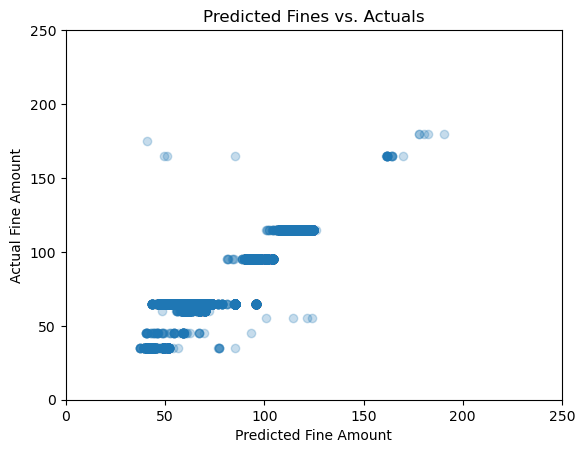

In [142]:
# make chart to visualize the results
ddf = dd.concat([dd.from_dask_array(c) for c in [y_test,yhat]], axis = 1) 

ddf.columns = ['ytest', 'yhat']
ddf_sampled = ddf.sample(frac=0.05).compute()

plt.plot(ddf_sampled['yhat'], ddf_sampled['ytest'], 'o', alpha=0.25)
plt.xlabel('Predicted Fine Amount')
plt.ylabel("Actual Fine Amount")
plt.title('Predicted Fines vs. Actuals')
plt.ylim([0,250])
plt.xlim([0,250])
